<a href="https://colab.research.google.com/github/simaafshar/MNase-data/blob/master/DL_for_tick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import package
import numpy as np
import cv2
import pandas as pd


In [ ]:
#Define a dataloader and dataset
#1)Dataset _> 2)Dataloader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
import cv2
import PIL
from torchvision.transforms import transforms
import pickle

# AutoAugment
class tick_dataset(Dataset):
  def __init__(self,path,train=True):
    if train:
      self.transform = transforms.Compose([transforms.ToPILImage(),transforms.RandomHorizontalFlip(),transforms.RandomRotation(20),transforms.RandomResizedCrop((224,224), scale=(0.2, 1.0)),
          transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
      with open('/content/drive/MyDrive/Tick_labels/train.pkl', 'rb') as f:
          self.data = pickle.load(f)

    else:
      self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
      with open('/content/drive/MyDrive/Tick_labels/test.pkl', 'rb') as f:
          self.data = pickle.load(f)


  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img = self.data[idx]['img']
    l1 = self.data[idx]['l1']
    l2 = self.data[idx]['l2']
    return self.transform(img),np.array(l1).reshape(1,1),np.array(l2).reshape(1,1)

  def imshow(self, idx):
    plt.imshow(self.data[idx]['img'])


In [ ]:
## Dataset

tick_train = tick_dataset("/content/drive/MyDrive/Tick Pics/*/*.JPG", train=True)
tick_test = tick_dataset("/content/drive/MyDrive/Tick Pics/*/*.JPG", train=False)

In [ ]:
print(len(tick_train))
print(len(tick_test))

791
199


[[0]] [[1]]


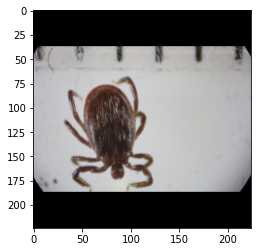

In [ ]:
## sample from dataset L1:sp, L2; Sex
img, l1,l2 = tick_train[10]
print(l1,l2)
tick_train.imshow(10)

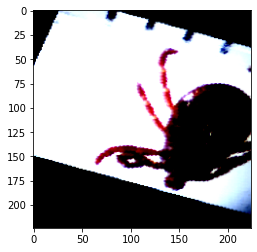

In [ ]:
# 47? 0:image47 -1:moveaxis took image 47 to the first (3,100,100) -> (100,100,3)

plt.imshow(np.moveaxis(tick_train[47][0].numpy(), 0, -1))
# plt.show()
# plt.imshow(tick_train[47])

In [ ]:
## groups of 16 images go throught into network

#Dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tick_train, batch_size=16, shuffle=True)
test_dataloader = DataLoader(tick_test, batch_size=16, shuffle=False)

In [ ]:
## define network
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU, Sigmoid, Sequential
class cnn(torch.nn.Module):
  def __init__(self):
    super(cnn,self).__init__()
    self.c1 = Conv2d(in_channels=3,out_channels=64,kernel_size=7)
    self.mp1 = MaxPool2d(3,2)
    self.c2 = Conv2d(in_channels=64,out_channels=10,kernel_size=5)
    self.mp2 = MaxPool2d(3,2)
    self.c3 = Conv2d(in_channels=10,out_channels=16,kernel_size=5)
    self.mp3 = MaxPool2d(3,2)
    self.c4 = Conv2d(in_channels=16,out_channels=16,kernel_size=5)
    self.mp4 = MaxPool2d(3,2)
    self.c5 = Conv2d(in_channels=16,out_channels=16,kernel_size=5)
    self.mp5 = MaxPool2d(3,2)
    self.flat = Flatten()
    self.l1 = Linear(1024,16)
    self.l_out_1 = Linear(16,1)
    self.l_out_2 = Linear(16,1)


  def forward(self,x):
    x = self.c1(x)
    x = ReLU()(x)
    x = self.c2(x)
    x = ReLU()(x)
    x = self.mp2(x)
    x = self.c3(x)
    x = ReLU()(x)
    x = self.mp3(x)
    x = self.c4(x)
    x = ReLU()(x)
    x = self.mp4(x)
    x = self.c5(x)
    x = ReLU()(x)
    x = self.mp5(x)
    x = self.flat(x)
    x = self.l1(x)
    o1 = self.l_out_1(x)
    o1 = Sigmoid()(o1)
    o2 = self.l_out_2(x)
    o2 = Sigmoid()(o2)
    return o1,o2


In [ ]:
#fully connected nn
class my_fc(torch.nn.Module):
  def __init__(self):
    super(my_fc,self).__init__()
    self.flat = Flatten()
    self.l1 = Linear(2048,16)
    self.l_out_1 = Linear(16,1)
    self.l_out_2 = Linear(16,1)


  def forward(self,x):
    x = self.flat(x)
    x = self.l1(x)
    o1 = self.l_out_1(x)
    o1 = Sigmoid()(o1)
    # o2 = self.l_out_2(x)
    # o2 = Sigmoid()(o2)
    return o1

my_fc_net = my_fc()

In [ ]:
network = cnn()

from torchvision.models import resnet50, mobilenet_v2, inception_v3, Inception_V3_Weights, vgg16, densenet121
#--------
network = resnet50(weights="IMAGENET1K_V2")
# network = vgg16(weights="IMAGENET1K_V1")
# network = mobilenet_v2(weights="IMAGENET1K_V1")
#--------
# network = inception_v3(weights="IMAGENET1K_V1")
# network = inception_v3(weights=Inception_V3_Weights)
# network = densenet121(weights="IMAGENET1K_V1")
network.fc = my_fc_net

network = network.cuda()
# print(network)

In [ ]:
# RGB:(type of image):3 , image size: 224*224?
from torchsummary import summary
summary(network, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
# layer numbers: 129
def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

print(len(get_children(network)))


129


In [ ]:
## : 50 times each samples go throught to be trained. learning rate: 0.001
#Training
from torch.nn import CrossEntropyLoss, BCELoss
from torch.optim import SGD, Adam
Epoch_number = 50
# loss_function = CrossEntropyLoss()
loss_function = BCELoss()
optimizor = SGD(network.parameters(),0.001)
optimizor = Adam(network.parameters())

In [ ]:
!pip install barbar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from barbar import Bar
from sklearn.metrics import accuracy_score

In [ ]:
# save loss
all_loss = []
best_acc = 0
#1 for DIV/IS and 2 for F/M
label_num = 2
for epoch in range(Epoch_number):
  print("Epoch: ", epoch)
  for images, l1 , l2 in Bar(train_dataloader):
    images = images.cuda()
    #Choose between l2 or l1
    if label_num==1:
      labels = l1.cuda().float()
    else:
      labels = l2.cuda().float()
    pred = network(images)
    # loss = loss_function(pred[0],labels_1[:,0])+loss_function(pred[1],labels_2[:,0])
    loss = loss_function(pred,labels[:,0])
    optimizor.zero_grad()
    loss.backward()
    optimizor.step()
    all_loss.append(loss.item())
  pred_all_1 = []
  label_all_1 = []
  pred_all_2 = []
  label_all_2 = []
  for images, l1 , l2 in Bar(test_dataloader):
    images = images.cuda()
    if label_num==1:
      labels = l1.cuda().float()
    else:
      labels = l2.cuda().float()
    pred = network(images)
    # pred_all_1 = np.concatenate((pred_all_1,pred[0].cpu().detach().numpy()[:,0]))
    pred_all_2 = np.concatenate((pred_all_2,pred.cpu().detach().numpy()[:,0]))
    # label_all_1 = np.concatenate((label_all_1, labels_1[:,0,0].cpu()))
    label_all_2 = np.concatenate((label_all_2, labels[:,0,0].cpu()))

  # acc_1 = accuracy_score((pred_all_1>0.5).astype('int'),label_all_1)
  # print("Accuracy on the test set is:",acc_1)
  acc_2 = accuracy_score((pred_all_2>0.5).astype('int'),label_all_2)
  print("Accuracy on the test set is:",acc_2)
  if (acc_2) > best_acc:
    print("Best accuracy is updated")
    print("Saving model...")
    best_acc = (acc_2)
    torch.save(network.state_dict(),"/content/drive/MyDrive/runs/model.pth")




Epoch:  0
791/791: [===============================>] - ETA 10.7s
199/199: [=============================>..] - ETA 0.1s
Accuracy on the test set is: 0.9095477386934674
Best accuracy is updated
Saving model...
Epoch:  1
791/791: [===============================>] - ETA 0.2s
199/199: [=============================>..] - ETA 0.1s
Accuracy on the test set is: 0.914572864321608
Best accuracy is updated
Saving model...
Epoch:  2
791/791: [===============================>] - ETA 0.2s
199/199: [=============================>..] - ETA 0.1s
Accuracy on the test set is: 0.8994974874371859
Epoch:  3
791/791: [===============================>] - ETA 0.2s
199/199: [=============================>..] - ETA 0.1s
Accuracy on the test set is: 0.9396984924623115
Best accuracy is updated
Saving model...
Epoch:  4
791/791: [===============================>] - ETA 0.2s
199/199: [=============================>..] - ETA 0.1s
Accuracy on the test set is: 0.9346733668341709
Epoch:  5
791/791: [=================

In [ ]:
## Acc
label_num = 2
network.load_state_dict(torch.load("/content/drive/MyDrive/runs/model.pth"))
pred_all_1 = []
label_all_1 = []
pred_all_2 = []
label_all_2 = []
loss_all = []
for images, l1 , l2 in Bar(test_dataloader):
  images = images.cuda()
  if label_num==1:
    labels = l1.cuda().float()
  else:
    labels = l2.cuda().float()
  pred = network(images)
  loss = loss_function(pred,labels[:,0])
  # pred_all_1 = np.concatenate((pred_all_1,pred[0].cpu().detach().numpy()[:,0]))
  pred_all_2 = np.concatenate((pred_all_2,pred.cpu().detach().numpy()[:,0]))
  # label_all_1 = np.concatenate((label_all_1, labels_1[:,0,0].cpu()))
  label_all_2 = np.concatenate((label_all_2, labels[:,0,0].cpu()))
  loss_all.append(loss.cpu().detach().numpy())
# acc_1 = accuracy_score((pred_all_1>0.5).astype('int'),label_all_1)
# print("Accuracy on the test set is:",acc_1)
acc_2 = accuracy_score((pred_all_2>0.5).astype('int'),label_all_2)
print("Accuracy on the test set is:",acc_2)

199/199: [=============================>..] - ETA 5.1s
Accuracy on the test set is: 0.9899497487437185


In [ ]:
loss_all_np = np.array(loss_all)
print(np.mean(loss_all_np))

0.035224736


In [ ]:
plt.plot(all_loss)

NameError: ignored

In [ ]:
print(network.avgpool)

AdaptiveAvgPool2d(output_size=(1, 1))


In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=9482bf0321d7e1762c870467b56c3b5216072b7fb25f3a50ecb1ba5d2c27aea0
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [ ]:
## from path define name of folder
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from PIL import Image

def grad_cam(path,label):
  folder = path[33:path.rfind('/')]
  side = path[-5:-4]
  target_layers = [network.layer4[-1]]
  # Convert the image to a tensor and normalize it
  image_path = path
  image = Image.open(image_path)
  transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
  image_tensor = transform(image).unsqueeze(0)
  image_tensor = image_tensor.cuda()

  input_tensor = image_tensor

  pred = network(input_tensor)
  pred=pred.cpu().detach().numpy()[0][0]
  # Create an input tensor image for your model..
  # Note: input_tensor can be a batch tensor with several images!

  # Construct the CAM object once, and then re-use it on many images:
  cam = GradCAM(model=network, target_layers=target_layers, use_cuda=True)

  # You can also use it within a with statement, to make sure it is freed,
  # In case you need to re-create it inside an outer loop:
  # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
  #   ...

  # # We have to specify the target we want to generate
  # # the Class Activation Maps for.
  # # If targets is None, the highest scoring category
  # # will be used for every image in the batch.
  # # Here we use ClassifierOutputTarget, but you can define your own custom targets
  # # That are, for example, combinations of categories, or specific outputs in a non standard model.

  targets = [ClassifierOutputTarget(0)]

  # # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

  # # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  img = plt.imread(image_path)/255.
  img = cv2.resize(img,(224,224))
  visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
  # plt.imshow(visualization)
  if label ==1:
    if pred>0.5:
      # plt.text(0.1, 0.1, "DV: %.3f"%pred, bbox=dict(fill=False, edgecolor='red', linewidth=2))
      plt.imsave("/content/drive/MyDrive/runs/DV/"+folder+"_"+side+"_%.3f.png"%(pred),visualization)
    else:
      # plt.text(0.1, 0.1, "DV: %.3f"%pred, bbox=dict(fill=False, edgecolor='red', linewidth=2))
      plt.imsave("/content/drive/MyDrive/runs/IS/"+folder+"_"+side+"_%.3f.png"%(pred),visualization)

  if label==2:
    if pred>0.5:
      # plt.text(0.1, 0.1, "DV: %.3f"%pred, bbox=dict(fill=False, edgecolor='red', linewidth=2))
      plt.imsave("/content/drive/MyDrive/runs/M/"+folder+"_"+side+"_%.3f.png"%(pred),visualization)
    else:
      # plt.text(0.1, 0.1, "DV: %.3f"%pred, bbox=dict(fill=False, edgecolor='red', linewidth=2))
      plt.imsave("/content/drive/MyDrive/runs/F/"+folder+"_"+side+"_%.3f.png"%(pred),visualization)

In [ ]:
grad_cam("/content/drive/MyDrive/Tick Pics/1A10/1A10_D.JPG",2)

In [ ]:
grad_cam("/content/drive/MyDrive/Tick Pics/1A2/1A2_V.JPG",2)

In [ ]:
##
import glob

paths = glob.glob("/content/drive/MyDrive/Tick Pics/*/*.JPG")
for i, path in enumerate(paths):
  grad_cam(path,label_num)
  print(i)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print(label_all_2[0:10])
print((pred_all_2[0:10]>0.5).astype('int'))

[0. 0. 1. 0. 1. 1. 0. 0. 1. 0.]
[0 0 1 0 1 1 0 0 1 0]


<AxesSubplot:>

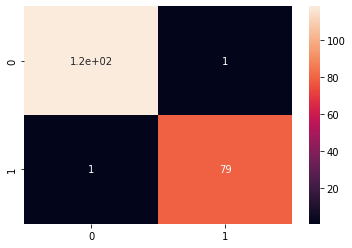

In [ ]:
# lable_all_2  0.5=T or F (0-1)
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(label_all_2, (pred_all_2>0.5).astype('int'))
sns.heatmap(cf_matrix, annot=True)